#### Advanced Statistics for Data Science (Spring 2022)
# Home Assignment 5
#### Topics:
- Contrasts
- Multiple TestinFalse-Discovery Rate
- Simple Regression

#### Due: 24/05/2022 by 18:30

#### Instructions:
- Write your name, Student ID, and date in the cell below. 
- Submit a copy of this notebook with code filled in the relevant places as the solution of coding excercises.
- For theoretic excercises, you can either write your solution in the notebook using $\LaTeX$ or submit additional notes.

<hr>
<hr>


**Name**: Eyal Michaeli

**Student ID**: 207380528

**Date**: 10.05.22

$
\newcommand{\Id}{{\mathbf{I}}}  
\newcommand{\SSE}{\mathsf{SSE}}
\newcommand{\SSR}{\mathsf{SSR}}
\newcommand{\MSE}{\mathsf{MSE}}
\newcommand{\simiid}{\overset{iid}{\sim}}
\newcommand{\ex}{\mathbb E}
\newcommand{\var}{\mathrm{Var}}
\newcommand{\Cov}[2]{{\mathrm{Cov}  \left(#1, #2 \right)}}
\newcommand{\one}[1]{\mathbf 1 {\left\{#1\right\}}}
\newcommand{\SE}[1]{\mathrm{SE} \left[#1\right]}
\newcommand{\reals}{\mathbb R}
\newcommand{\Ncal}{\mathcal N}
\newcommand{\abs}[1]{\ensuremath{\left\vert#1\right\vert}}
\newcommand{\rank}{\operatorname{rank}}
\newcommand{\tr}{\operatorname{Tr}}
\newcommand{\diag}{\operatorname{diag}}
\newcommand{\sign}{\operatorname{sign}}
$


<hr>
<hr>

## Problem 1 (Multiple testing in Practice)
#### Continuation of Problem 4 from HW4

In HW4, Problem 4 you used ANOVA to measure the effect of the winary (``winary``) on the quality (``points``) of wines from veriaty (``veriaty``) ``Cabernet Sauvignon``. Using the same dataset (reduced to Israeli wines and a specific veriaty). You used all t-tests involving pairs of winaries and reported pairs found significant after a Bonfferoni's correction. In this question, you will use Binjamini-Hochberg's (BH) FDR controlling procedure as an alternative to Bonfferoni. 
 1. Using HW4, Problem 4, consider P-values from all t-tests of pairs of winaries. Sort the P-values from small to large and plot the smallest 10% of the sorted list of P-values on a stem or a scatter plot in which the x-axis indicate the P-value rank (left most point is rank = 1, i.e., the smallest) and the y-axis the P-value's value. 
 2. Assume that different tests are independet; apply BH to select a set of winary pairs in which one winary is significantly better than the others while aiming for 0.05 false pairs. How many pairs were reported? is it more or less pairs than you discovered using Bonfferoni correction in HW4, Problem 4?
 3. Repeat the last item without the independence assumption, i.e., use the harmonic sum correction.
 
The point: FDR controlling using BH is a more liberal (less conservative) approach to identify significnat discoveries in the sense that it allows us to report on more discoveries if we are willing to replace family-wise error rate control with an expected false-discovery proportion guarantee.  

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels as sm
import math
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(style="darkgrid")
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] =  [15, 10]


In [2]:
raw_df = pd.read_csv('winemag-data_first150k.csv')

# filter to contain only israeli wines of variety Cabernet Sauvignon
raw_df = raw_df[(raw_df.country == 'Israel') & (raw_df.variety == 'Cabernet Sauvignon')]

# keep relavent columns
raw_df = raw_df[['winery', 'points']]

raw_df.head()

,winery,points
81,Binyamina,91
355,Bazelet HaGolan,91
966,Segal's,90
970,Tabor,90
977,Yatir,90


In [3]:
winery_counts = raw_df.winery.value_counts()

wineries_more_than_1 = winery_counts[winery_counts > 1].index

df = raw_df[raw_df.winery.isin(wineries_more_than_1)]
print(f"We removed {len(raw_df) - len(df)} rows from the data\n")

df.sample(5)

We removed 7 rows from the data



,winery,points
35688,Barkan,89
52552,Carmel,85
108421,Katlav,86
46332,Golan Heights Winery,87
9574,Titora,86


Re-run peoblem 4 (normal p-values)

In [4]:
# for later use

variable = 'points'

def ssquares(x):
    return np.sum((x - np.mean(x)) ** 2)

ss_wit = df.groupby('winery')[variable].agg(ssquares).sum()
ss_tot = np.sum((df[variable] -  df[variable].mean()) ** 2)

n = len(df)
k = len(wineries_more_than_1)

ss_bet = ss_tot - ss_wit

MSE_bet = ss_bet / (k-1)
MSE_wit = ss_wit / (n-k)

n, k

(135, 19)

In [10]:
EPSILON = 10 ** -6

def two_sample_t(data1, data2):
    data1_mean = np.mean(data1)
    data2_mean = np.mean(data2)
    
    n0 = len(data1)
    n1 = len(data2)
    dof = n0 §+ n1 - 2
    
    s = np.sqrt((np.sum((data1-data1_mean)**2) + np.sum((data2-data2_mean)**2)) / dof)
    
    s = max(EPSILON, s)
    
    t_statistic = (data2_mean - data1_mean) / (s * np.sqrt(1 / n0 + 1 / n1))
    p_val = stats.t.sf(abs(t_statistic), dof)

    return t_statistic, p_val, dof


wineries_pairs = [(winery_1, winery_2) for idx, winery_1 in enumerate(wineries_more_than_1) for winery_2 in wineries_more_than_1[idx + 1: ]]
print(f"There are {len(wineries_pairs)} t-tests to be done")

tests_pvals = list()
for winery_1, winery_2 in wineries_pairs:
    data1 = df[df.winery == winery_1]["points"]
    data2 = df[df.winery == winery_2]["points"]
    
    t_stat, p_val, dof = two_sample_t(data1, data2)

    tests_pvals.append(p_val)


ALPHA = 0.05
p_vals_significant = [p_val for p_val in tests_pvals if p_val < ALPHA / 2] 


print(f"\nThere are {len(p_vals_significant)} out of {len(wineries_pairs)} total p-values that are significantly lower than {ALPHA}")

print(f"\nUnder null hypothisis we expect to reject {len(wineries_pairs) * ALPHA // 1}, and we rejected {len(p_vals_significant)}.")

There are 171 t-tests to be done

There are 59 out of 171 total p-values that are significantly lower than 0.05

Under null hypothisis we expect to reject 8.0, and we rejected 59.


 1. Using HW4, Problem 4, consider P-values from all t-tests of pairs of winaries. Sort the P-values from small to large and plot the smallest 10% of the sorted list of P-values on a stem or a scatter plot in which the x-axis indicate the P-value rank (left most point is rank = 1, i.e., the smallest) and the y-axis the P-value's value. 
 

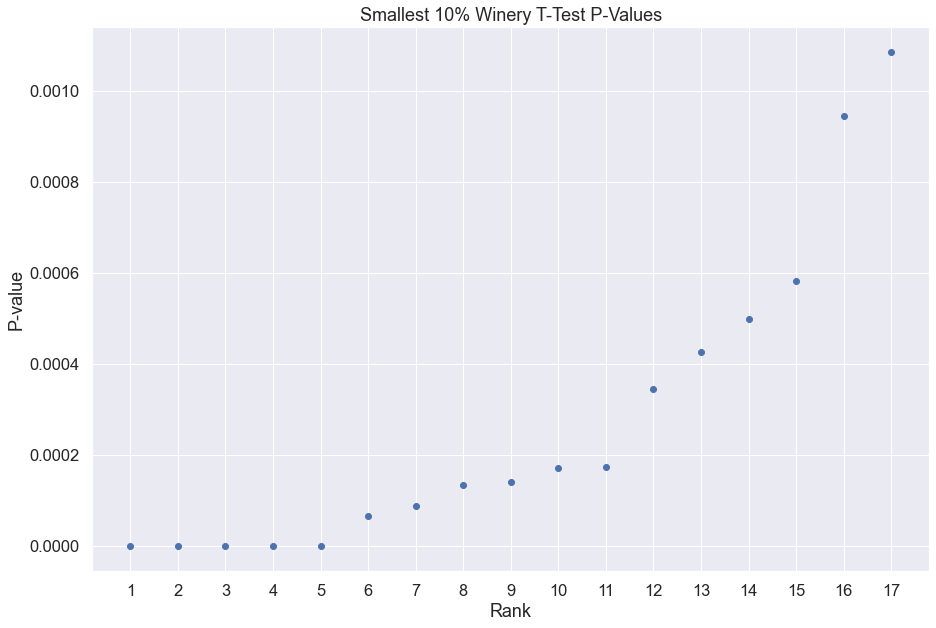

In [68]:
smallest_p_vals = np.sort(tests_pvals)[: int(len(tests_pvals) * 0.1)]

f, ax = plt.subplots(1, 1)

plt.scatter(range(1, len(smallest_p_vals)+1), smallest_p_vals)
plt.title("Smallest 10% Winery t-test p-values".title())
plt.xlabel('Rank')
plt.ylabel('P-value')
plt.xticks(range(1, len(smallest_p_vals)+1))
plt.show()

let's plot with a log y scale as well:

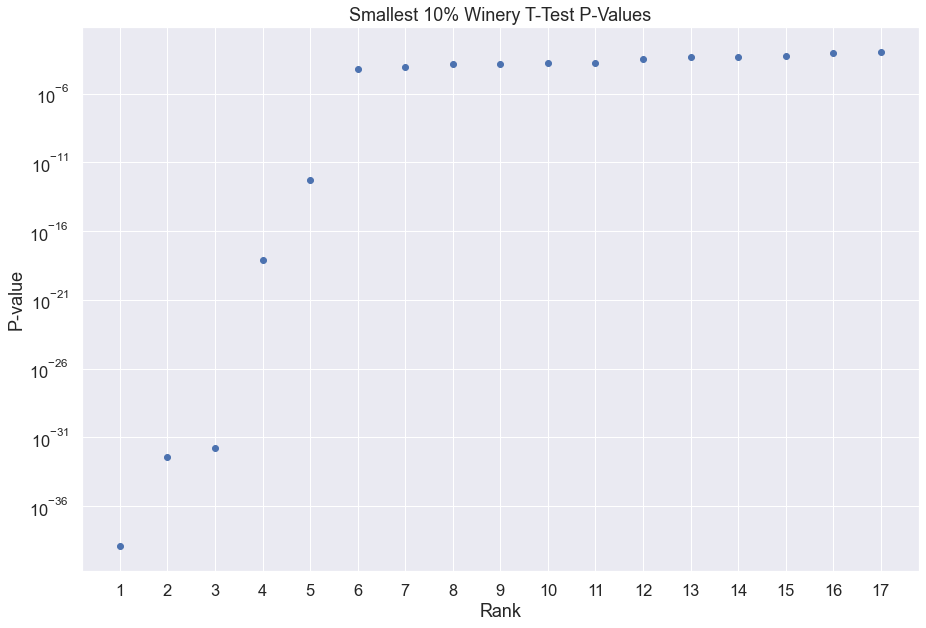

In [69]:
sorted_pvals = np.sort(tests_pvals)
idcs = np.argsort(tests_pvals)  # for late use
smallest_p_vals = sorted_pvals[: int(len(tests_pvals) * 0.1)]

f, ax = plt.subplots(1, 1)

plt.scatter(range(1, len(smallest_p_vals)+1), smallest_p_vals)
plt.title("Smallest 10% Winery t-test p-values".title())
plt.xlabel('Rank')
plt.ylabel('P-value')
plt.xticks(range(1, len(smallest_p_vals)+1))
plt.yscale("log")

plt.show()

 2. Assume that different tests are independet; apply BH to select a set of winary pairs in which one winary is significantly better than the others while aiming for 0.05 false pairs. How many pairs were reported? is it more or less pairs than you discovered using Bonfferoni correction in HW4, Problem 4?
 

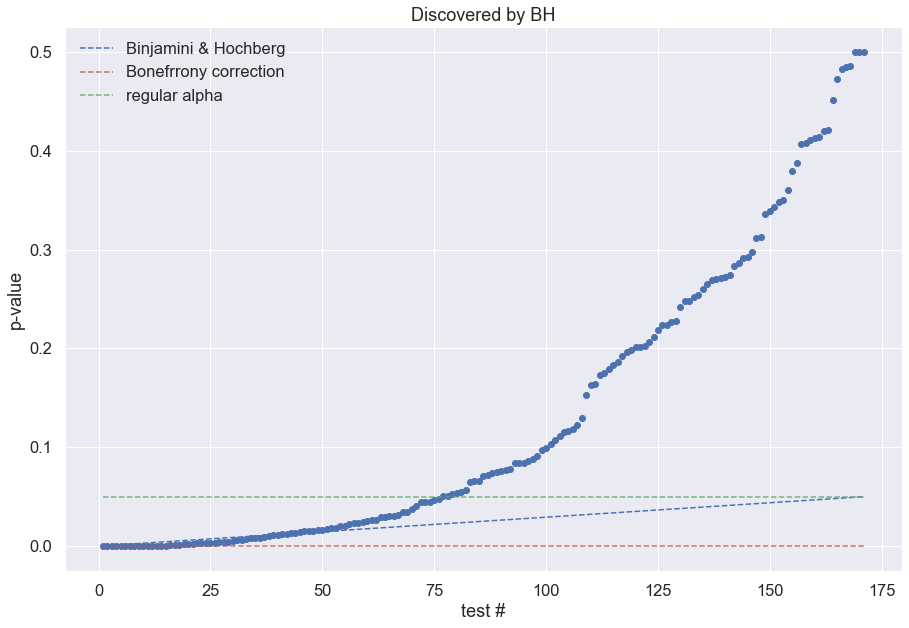


Discovered by BH:
There were 40/171 significant t tests
As opposed to 9 rejections using Bonferroni correction
So, of course using BH we have more rejections, perhaps Bonferroni is too conservative


In [55]:

plt.scatter(np.arange(1, len(sorted_pvals)+1), sorted_pvals)

# Discoveries by Bonferroni's:
m = len(sorted_pvals)
alpha = 0.05
q = 0.05
ell = np.arange(1, m+1) / m * q
plt.plot(np.arange(1,m+1), ell, '--b', label="Binjamini & Hochberg")

plt.plot([1, m], [alpha / m, alpha / m], '--r', alpha=.8, label="Bonefrrony correction")
plt.plot([1, m], [alpha, alpha], '--g',  alpha=.8, label="regular alpha")

plt.ylabel('p-value')
plt.xlabel('test #')
plt.title("Discovered by BH")
plt.legend()
plt.show()

# Discoveries by BH:
rejected = sorted_pvals < ell

print("\nDiscovered by BH:")
print(f"There were {np.sum(rejected)}/{len(rejected)} significant t tests")
print("As opposed to 9 rejections using Bonferroni correction")
print("So, of course using BH we have more rejections, perhaps Bonferroni is too conservative")

Let's 'zoom in' to get a better understanding of the relative position of the lines & data:

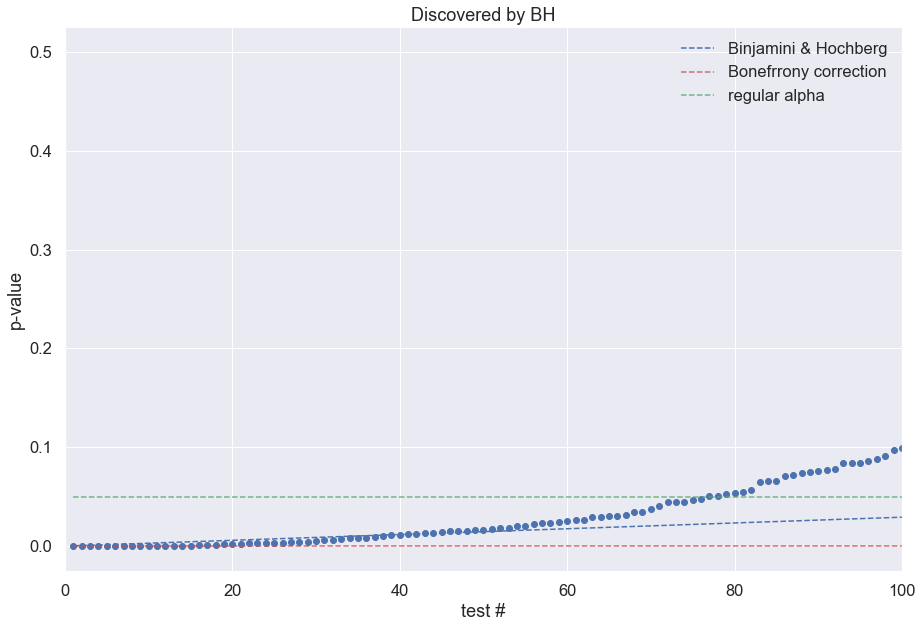


Discovered by BH:
There were 40/171 significant t tests
As opposed to 9 rejections using Bonferroni correction
So, of course using BH we have more rejections, perhaps Bonferroni is too conservative


In [54]:

plt.scatter(np.arange(1, len(sorted_pvals)+1), sorted_pvals)

# Discoveries by Bonferroni's:
m = len(sorted_pvals)
alpha = 0.05
q = 0.05
ell = np.arange(1, m+1) / m * q
plt.plot(np.arange(1,m+1), ell, '--b', label="Binjamini & Hochberg")

plt.plot([1, m], [alpha / m, alpha / m], '--r', alpha=.8, label="Bonefrrony correction")
plt.plot([1, m], [alpha, alpha], '--g',  alpha=.8, label="regular alpha")

plt.ylabel('p-value')
plt.xlabel('test #')
plt.title("Discovered by BH")
plt.legend()
plt.xlim(0, 100) # 100 smallest p values
plt.show()

# Discoveries by BH:
rejected = sorted_pvals < ell

print("\nDiscovered by BH:")
print(f"There were {np.sum(rejected)}/{len(rejected)} significant t tests")
print("As opposed to 9 rejections using Bonferroni correction")
print("So, of course using BH we have more rejections, perhaps Bonferroni is too conservative")

 3. Repeat the last item without the independence assumption, i.e., use the harmonic sum correction.
 

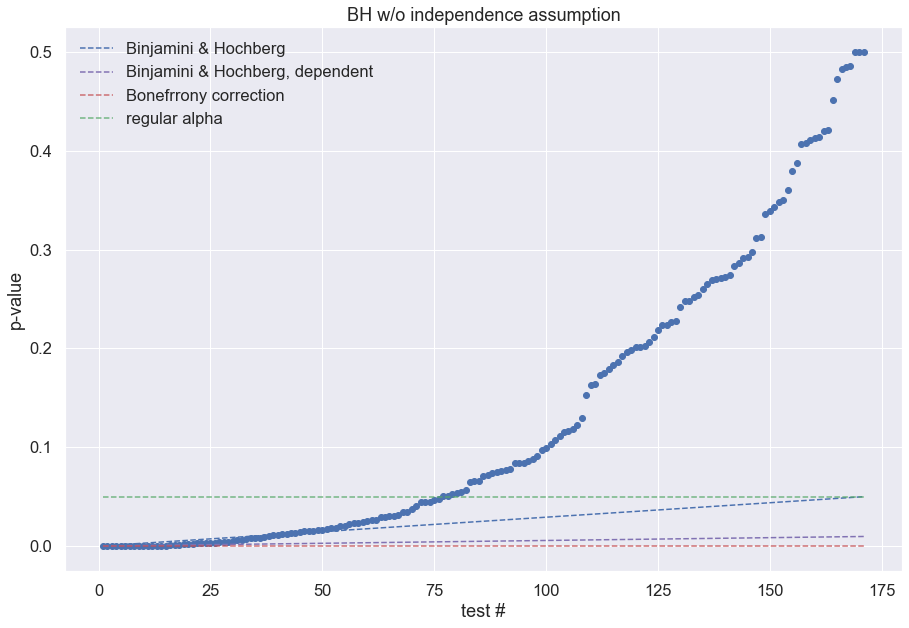


Discovered by BH w/o independence assumption:
There were 15/171 significant t tests
As opposed to 9 rejections using Bonferroni correction
So, of course using BH, even not dependent, we have more rejections, perhaps Bonferroni is too conservative


In [65]:

plt.scatter(np.arange(1, len(sorted_pvals)+1), sorted_pvals)

# Discoveries by Bonferroni's:
q = 0.05
ell = np.arange(1, m+1) / m * q
ell_dep = np.arange(1, m+1) / m * q / (np.log(m))

plt.plot(np.arange(1,m+1), ell, '--b', label="Binjamini & Hochberg")
plt.plot(np.arange(1,m+1), ell_dep, '--m', label="Binjamini & Hochberg, dependent")

plt.plot([1, m], [alpha / m, alpha / m], '--r', alpha=.8, label="Bonefrrony correction")
plt.plot([1, m], [alpha, alpha], '--g',  alpha=.8, label="regular alpha")

plt.ylabel('p-value')
plt.xlabel('test #')
plt.title("BH w/o independence assumption")
plt.legend()
plt.show()


rejected = sorted_pvals < ell_dep

print("\nDiscovered by BH w/o independence assumption:")
print(f"There were {np.sum(rejected)}/{len(rejected)} significant t tests")
print("As opposed to 9 rejections using Bonferroni correction")
print("So, of course using BH, even not dependent, we have more rejections, perhaps Bonferroni is too conservative")


Let's 'zoom in' here as well:

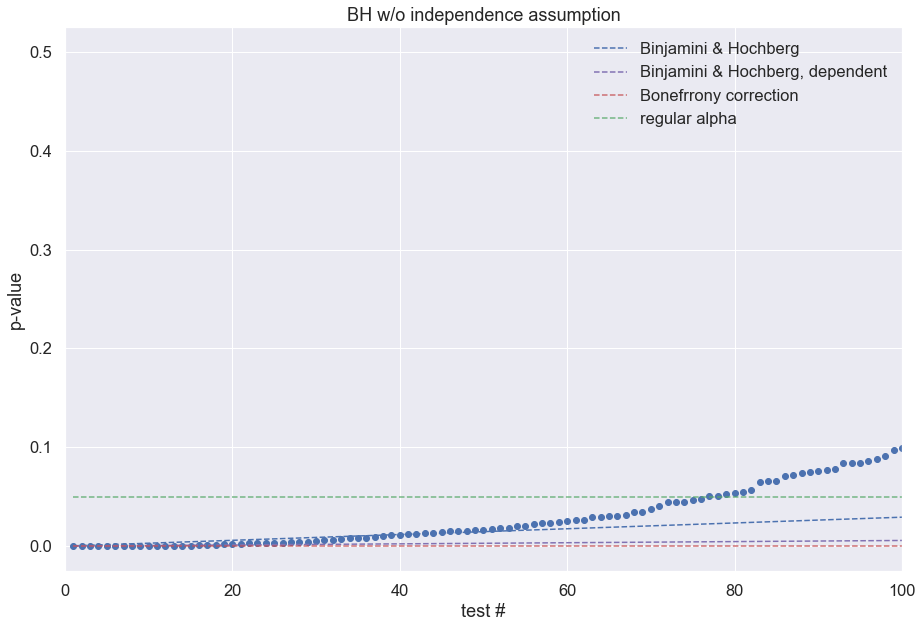


Discovered by BH w/o independence assumption:
There were 15/171 significant t tests
As opposed to 9 rejections using Bonferroni correction
So, of course using BH, even not dependent, we have more rejections, perhaps Bonferroni is too conservative


In [66]:

plt.scatter(np.arange(1, len(sorted_pvals)+1), sorted_pvals)

# Discoveries by Bonferroni's:
q = 0.05
ell = np.arange(1, m+1) / m * q
ell_dep = np.arange(1, m+1) / m * q / (np.log(m))

plt.plot(np.arange(1,m+1), ell, '--b', label="Binjamini & Hochberg")
plt.plot(np.arange(1,m+1), ell_dep, '--m', label="Binjamini & Hochberg, dependent")

plt.plot([1, m], [alpha / m, alpha / m], '--r', alpha=.8, label="Bonefrrony correction")
plt.plot([1, m], [alpha, alpha], '--g',  alpha=.8, label="regular alpha")

plt.ylabel('p-value')
plt.xlabel('test #')
plt.title("BH w/o independence assumption")
plt.legend()
plt.xlim(0, 100)
plt.show()


rejected = sorted_pvals < ell_dep

print("\nDiscovered by BH w/o independence assumption:")
print(f"There were {np.sum(rejected)}/{len(rejected)} significant t tests")
print("As opposed to 9 rejections using Bonferroni correction")
print("So, of course using BH, even not dependent, we have more rejections, perhaps Bonferroni is too conservative")


## Problem 2 (contrasts)
#### Continuation of Problem 1

Using a single t-test, test the assumption that the average of the Golan area wineries: ``Bazelet HaGolan``, ``Gamla``, ``Golan Heights Winary`` have the same quality as the average of Judean Hills area wineries: ``Katlav``, ``Psagot``, ``Shiloh Winery``, ``Titora``, ``Yatir`` (the goal here is to construct a "contrast", hence you should take an arithmetic average of group averages. You should only consider the size of each individual group when evaluating the varaince of the contrast).

Note: you can ignore the ``province`` filed in the data becasue it contains inaccurate information. You should also ignore the fact that in reality, ``Gamla`` is produced by ``Golan Heights Winary``. 



In [5]:
golan_wineries = ["Bazelet HaGolan", "Gamla", "Golan Heights Winery"]
judean_wineries = ["Katlav", "Psagot", "Shiloh Winery", "Titora", "Yatir"]
all_wineries = golan_wineries + judean_wineries

# t numerator
golan_avg = np.sum([np.mean(df[df.winery == winery]["points"]) for winery in golan_wineries]) / len(golan_wineries)
judean_avg = np.sum([np.mean(df[df.winery == winery]["points"]) for winery in judean_wineries]) / len(judean_wineries)

t_numerator = golan_avg - judean_avg

# t dinominator
s = np.sqrt(MSE_wit)

golan_part = len(golan_wineries) ** 2 * np.sum( [1 / len(df[df.winery == winery]["points"]) for winery in golan_wineries])
judean_part = len(judean_wineries) ** 2 * np.sum( [1 / len(df[df.winery == winery]["points"]) for winery in judean_wineries])

t_dinominator = s * np.sqrt(golan_part * judean_part) 

t_stat = t_stat_numerator / t_stat_denominator
dof = np.sum( [len(df[df.winery == winery]["points"]) for winery in golan_wineries]) - len(all_wineries)
             
pvalue = stats.t.sf(abs(t_stat), dof)
print(pvalue)
ALPHA = 0.05
reject = "reject" if pvalue < ALPHA else "CAN'T reject"
print(f"We {reject} H0 that Golan area wineries have the same quality(in terms of POINTS) as Judean area wineries "
      f"with alpha = {ALPHA}, and with p-value = {t_stat_pvalue:.5f}")

NameError: name 't_stat_numerator' is not defined

## Problem 3 (Exact size of Bonferroni's test)
Suppose that we run multiple tests with independent data and obtain P-values $p_1,\ldots,p_n$. We wish to test the null hypothesis:
$$
H_0\,:\,\text{All tests are null}
$$
at the level $\alpha$ (e.g., $\alpha=0.05$). In class, we introduced Bonferroni's procedure which is equivalent to: Reject $H_0$ if $\min p_i \leq \alpha/n$. 
1. Show that the  size of the test in Bonferroni's procedure is at most $\alpha$, regardless if the hypotheses are independent or not. 
2. Assuming that the hypotheses are independent, find the exact size of the test in Bonferroni's procedure. 
3. For $\alpha=0.05$, evalaute the difference between $\alpha$ and the exact test's size for $n=2,...,50$. Discuss what you see. 



## Problem 4 (Prediction in Simple Regression)
Consider the linear model:
$$
    y_i = \beta_0 + \beta_1 x_i + \epsilon_i,\qquad \epsilon_i \simiid \Ncal(0,\sigma^2)
$$
$$
    Z = \begin{pmatrix}
    1 & x_1 \\
    \vdots & \vdots \\
    1 & x_n
    \end{pmatrix},\quad \beta=\begin{pmatrix}
    \beta_0 \\
    \beta_1
    \end{pmatrix},\qquad \hat{\beta}=(Z^\top Z)^{-1} Z^\top y
$$
Suppose we get a new data point $x_{n+1}$ and want to predict $y_{n+1}$. We want an interval in which this prediction will likely to land. In class, we used that 
$$
\var[\hat{\beta}_0 + \hat{\beta}_1 x] = \frac{\sigma^2}{n} \left( \frac{1}{n} + \frac{(x-\bar{x})^2}{S_{XX }}\right)
$$
to obtain a confidence interval for $\beta_0 + \beta_1 x$, and a confidence band for all $x \in \reals$. In this question, you will use a similar reasoning to get a confidence interval (and bands) for $y_{n+1}$.
1. Find the varaince of $y_{n+1} - (\hat{\beta}_0 + \hat{\beta}_1 x_{n+1})$ in terms of $\sigma^2$ and $x_1,\ldots,x_n$ and $x_{n+1}$ (you can use $\bar{x}$ and $S_{XX}$ or any other well-defined function of $x_1,\ldots,x_n$). Explain intuitively why it makes sense that this variance is larger than the variance of  $\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}$. 
2. Find a $1-\alpha$ confidence interval for $y_{n+1}$. Is this interval wider or narrower than that of $\hat{\beta}_0 + \hat{\beta}_1 x_{n+1}$? For what value of $x_{n+1}$ this interval is the narrowest?
3. Suppose that we take the average of two responses $y$'s at the same $x_{n+1}$, say 
$$
y_{n+1} =  \frac{y_{n+1}^{(1)} + y_{n+1}^{(2)}}{2}, 
$$
where
$$
y_{n+1}^{(1)} = \beta_0 + \beta_1 x_{n+1} + \epsilon_{n+1}^{(1)}
$$
and 
$$
y_{n+1}^{(2)} = \beta_0 + \beta_1 x_{n+1} + \epsilon_{n+1}^{(2)},
$$
where $\epsilon_{n+1}^{(1)}$ and $\epsilon_{n+1}^{(2)}$ are independent. Find a confidence interval for $y_{n+1}$. Is it wider or narrower than the interval in (2) ?

Note: The confidence interval you derived in 2 is somewhat risky to use becasue it makes the strong assumption that $\epsilon_{n+1}$ is normal. This is compared to, say, confidence intrvals for $\hat{\beta}_0$ and $\hat{\beta}_1$ which rely on averages over all observations $y_1,\ldots,y_n$ so we can use the Central Limit Theorem to argue for normality. Thigs gets better both in terms of varaince and normality assumption when you can take multiple measurements at the same $x_{n+1}$ and average those. 
